# Evaluate Dataset

## Run the Dataset in turn.

In [ ]:
# 

## Generate code with llm and run with log and plot.

load from disk: Vectorstore/chromadb-MCCoder


Processing tasks:   0%|          | 0/3 [00:00<?, ?it/s]

6
codedeta:Program begin.
Program End.
, Elapsed_time: 3.264
codeerr:
end


Processing tasks:  33%|███▎      | 1/3 [00:13<00:26, 13.21s/it]

# -------------------------------------------------------------------------

7
codedeta:Program begin.
Program End.
, Elapsed_time: 3.134
codeerr:
end


Processing tasks:  67%|██████▋   | 2/3 [00:23<00:11, 11.78s/it]

# -------------------------------------------------------------------------

8
codedeta:Program begin.
Program End.
, Elapsed_time: 2.972
codeerr:
end


Processing tasks: 100%|██████████| 3/3 [00:35<00:00, 11.88s/it]

# -------------------------------------------------------------------------

Overall Results:
  Total Correct: 3 (100.00%)
  Total Syntax Error: 0 (0.00%)
  Total Other Error: 0 (0.00%)

Difficulty: 1
  Correct: 1 (100.00%)
  Syntax Error: 0 (0.00%)
  Other Error: 0 (0.00%)

Difficulty: 2
  Correct: 2 (100.00%)
  Syntax Error: 0 (0.00%)
  Other Error: 0 (0.00%)

Difficulty: 3


ZeroDivisionError: division by zero

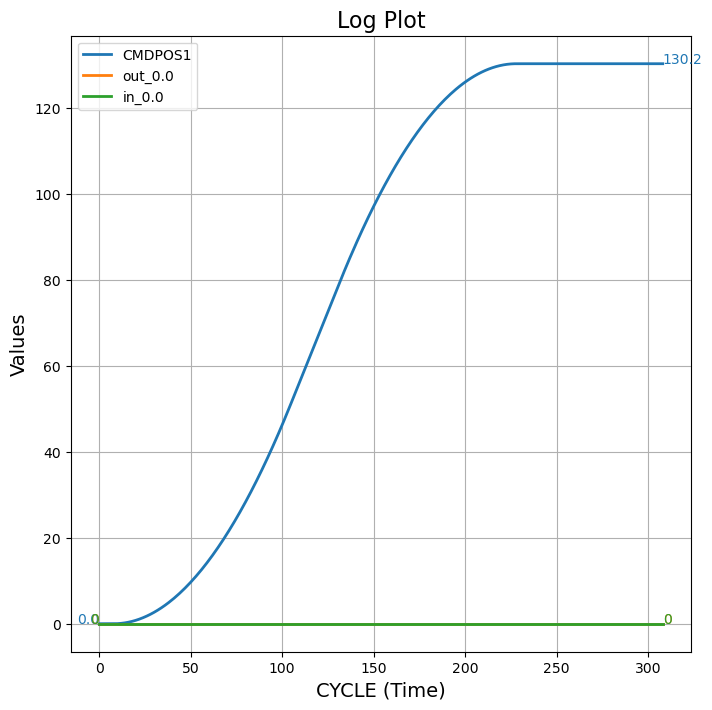

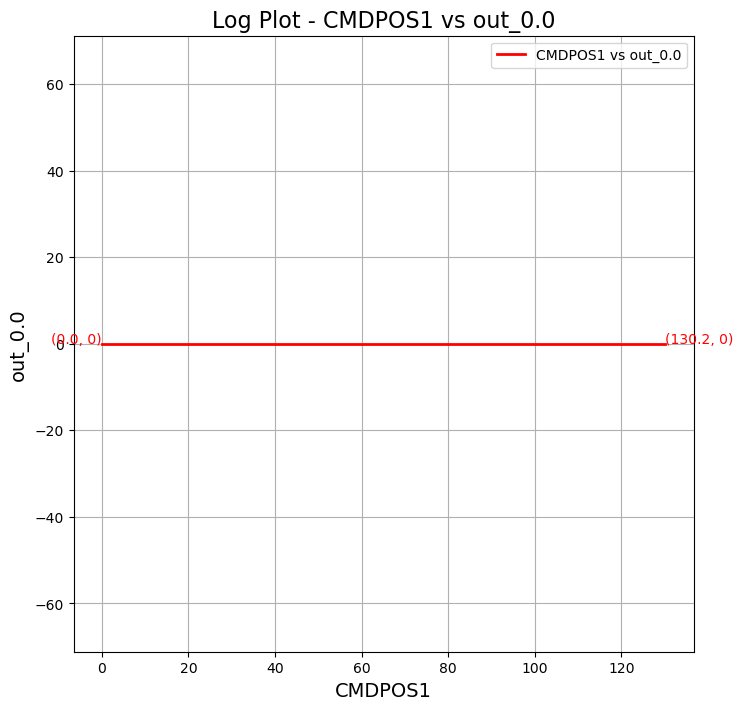

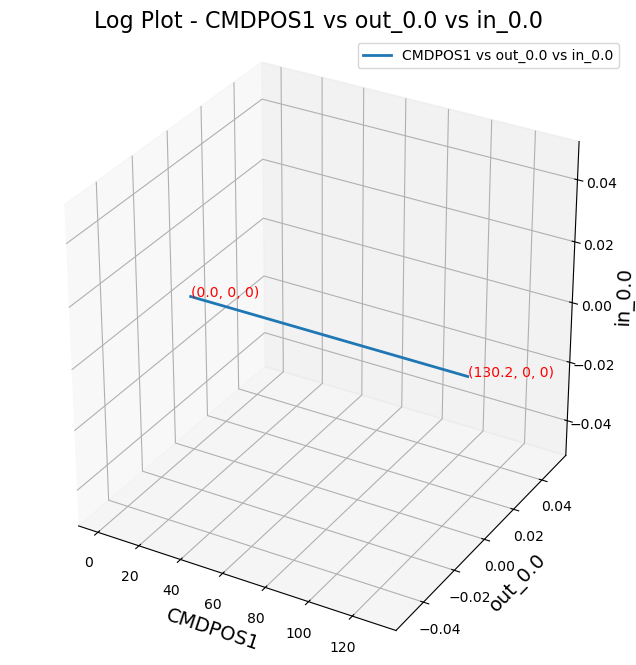

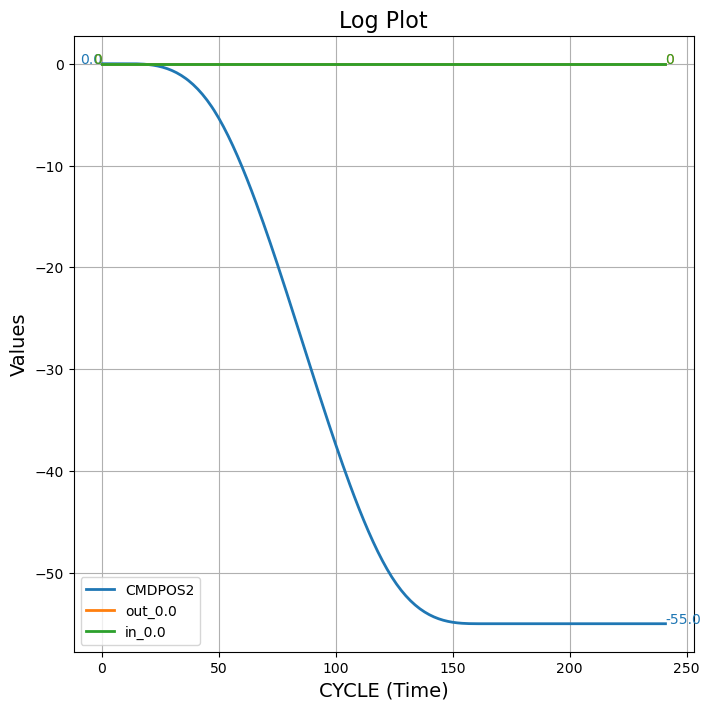

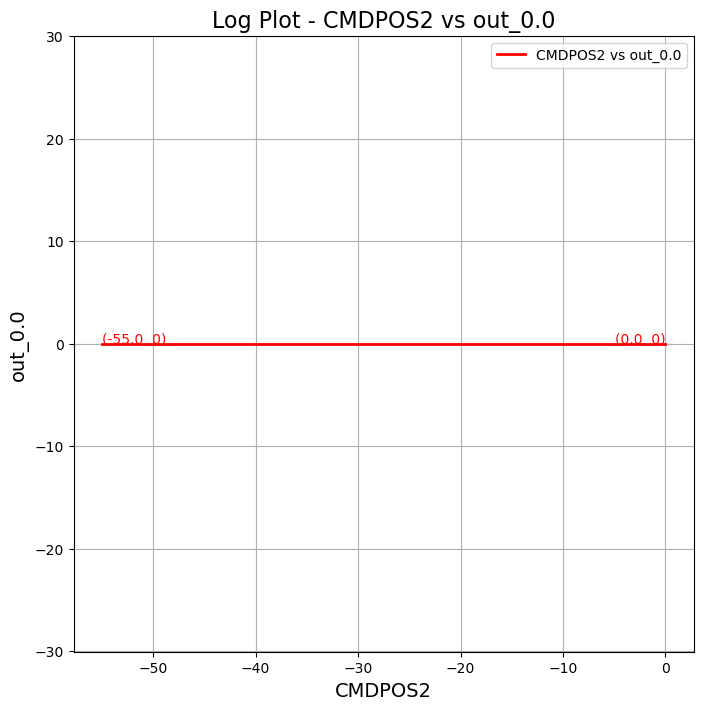

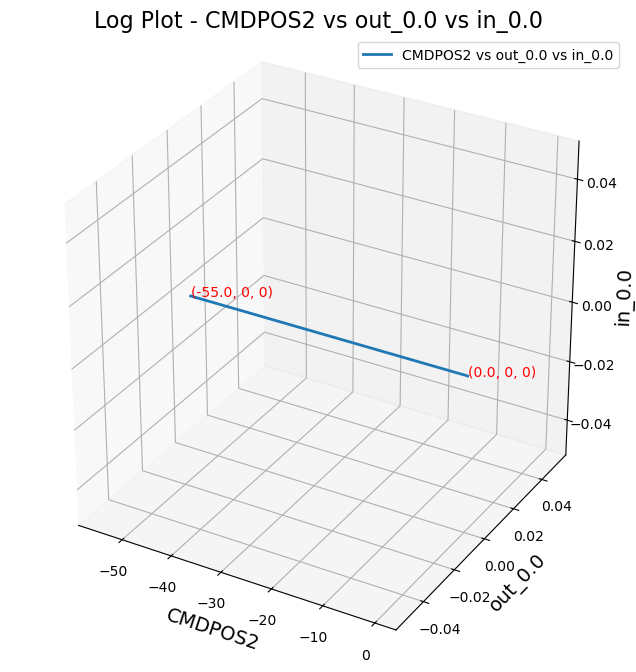

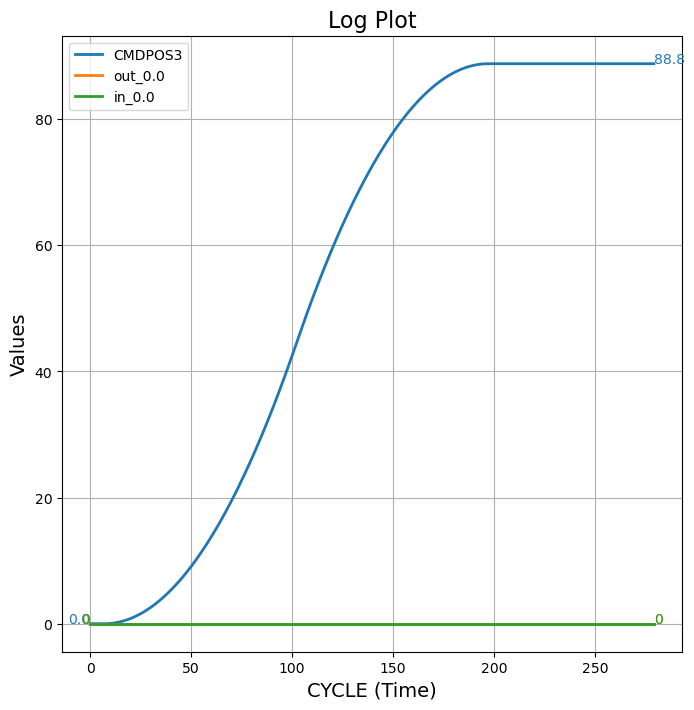

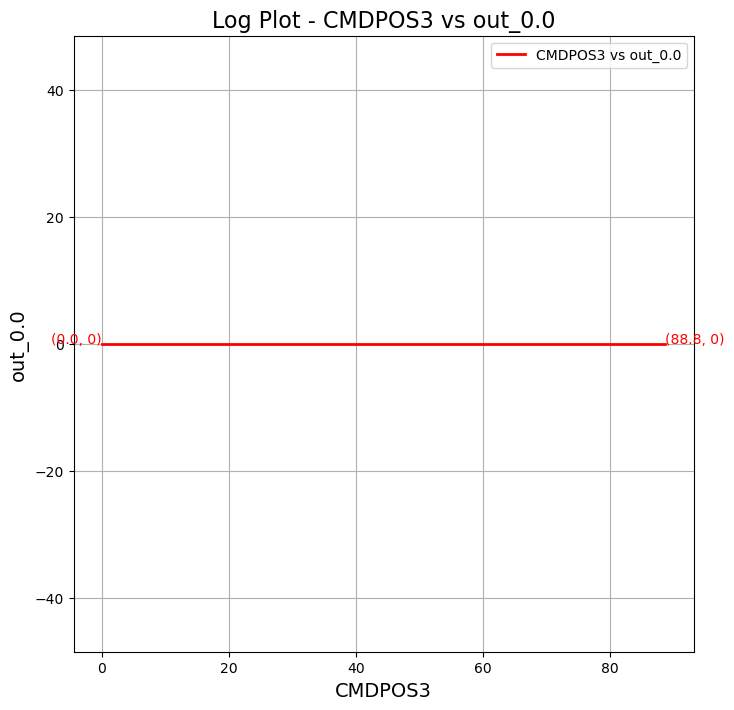

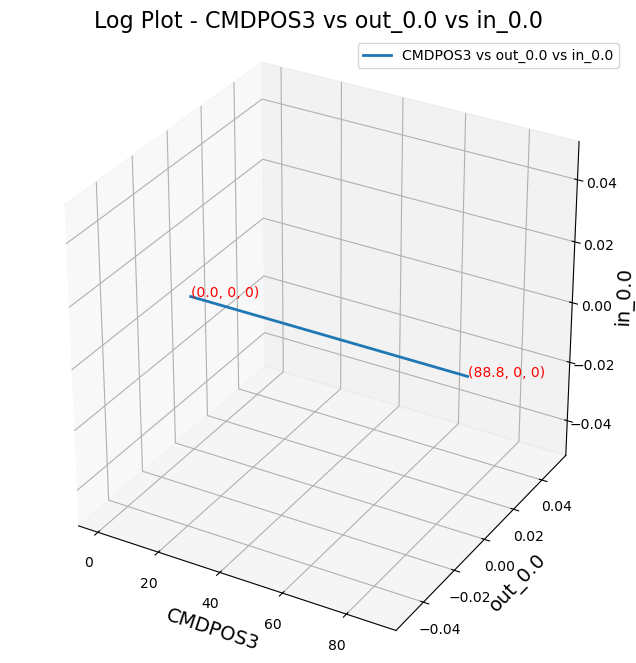

In [1]:

from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain.schema import StrOutputParser
from langchain.schema.runnable import Runnable
from langchain.schema.runnable.config import RunnableConfig

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader, TextLoader, PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings, OpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import PromptTemplate
from langchain_core.documents import Document
from langchain.chains import LLMChain
from langchain_core.messages import HumanMessage, SystemMessage

from time import *

from CodeClient import *
from make_code_runnable import *
from plot_log import *
from tqdm import tqdm
import json
import os
import re
from dotenv import load_dotenv,find_dotenv


# Global variable to store the name of the LLM
llm_name = "gpt-4o"
llm = ChatOpenAI(name="MCCoder and QA", model_name=llm_name, temperature=0.2, streaming=True)

# Prepare docs for RAG

load_dotenv(find_dotenv()) 

# Preparation of documents for RAG-------------------------
# Vectorstore, for retrieval
embedding_model=OpenAIEmbeddings(model="text-embedding-3-large")   #text-embedding-3-large   #text-embedding-ada-002    #text-embedding-3-small

# If pdf vectorstore exists
vectorstore_path = "Vectorstore/chromadb-MCCoder"
if os.path.exists(vectorstore_path):
    vectorstore = Chroma(
                    embedding_function=embedding_model,
                    persist_directory=vectorstore_path,
                    ) 
    print("load from disk: " + vectorstore_path)
else:
        # Load from chunks and save to disk
    # vectorstore = Chroma.from_documents(documents=splits, embedding=embedding_model, persist_directory=vectorstore_path) 
    print("load from chunks")

retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

# Txt loader of sample codes, for BM25 search
loader = TextLoader("./docs/WMX3API_MCEval_Samplecodes.txt")
docs = loader.load()

#Sample code chunk with dedicated separators
separators = ['``']  # Adjust based on actual document structure, `` is the end of each code snippet.
text_splitter = RecursiveCharacterTextSplitter(separators=separators, keep_separator=True, chunk_size=1000, chunk_overlap=200, add_start_index=True)
splits = text_splitter.split_documents(docs)



# Extracts and formats code instructions from a user question based on specific starting phrases.
def coder_router(user_question):
    """
    Extracts numbered sections of a user question based on specific starting phrases.
    
    If the question starts with 'Write a python code', 'Python code', or 'write python' (case insensitive),
    it splits the question into paragraphs that start with numbers (e.g., 1., 2., 3.) and adds 
    'Write python code to ' after the numbers. If the question does not start 
    with the specified phrases or does not contain numbered lists, the entire question is saved into a single 
    element array. If the question does not start with the specified phrases, NoCoder is set to 1.
    
    Args:
        user_question (str): The user's question.
    
    Returns:
        tuple: NoCoder (int), an array of strings with each element containing a code instruction or the entire question.
    """
    result = []
    NoCoder = 0
    # Check if the input starts with the specified prefixes
    if re.match(r'(?i)^(Write a python code|Python code|write python)', user_question):
        result.append(user_question)
    else:
        # Save the entire question to the array and set NoCoder to 1
        result.append(user_question)
        NoCoder = 1
    
    return NoCoder, result



# This function retrieves and concatenates documents for each element in the input string array.
def coder_retrieval(coder_router_result):
    """
    This function takes an array of strings as input. For each element in the array,
    it performs a retrieval using format_docs(retriever.invoke(element))
    and concatenates the element with the retrieval result into one long string, 
    with a newline character between them. Each concatenated result is separated by a specified separator.
    
    Args:
        coder_router_result (list): An array of strings.

    Returns:
        str: A single long string formed by concatenating each element with its retrieval result,
             separated by a newline character, and each concatenated result separated by a specified separator.
    """
    separator = "\n----------\n"
    long_string = ""
    for element in coder_router_result:

        # Fusion retrieval or hybrid search
        from langchain.retrievers import BM25Retriever, EnsembleRetriever

        # initialize the bm25 retriever and faiss retriever
        bm25_retriever = BM25Retriever.from_documents(splits)
        bm25_retriever.k = 5

        # initialize the ensemble retriever
        ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, retriever], weights=[0.5, 0.5])

        ensemble_docs = ensemble_retriever.get_relevant_documents(element)

        retrieval_result = format_docs(ensemble_docs)
        long_string += element + "\n" + retrieval_result + separator
    
    return long_string


# Joins the page content of each document with double newline
def format_docs(docs):
   return "\n\n".join(doc.page_content for doc in docs)


# Extracts code snippets written in Python from the given text
def extract_code(text):
    # Define the regular expression pattern to find text between ```python and ```
    pattern = r"```python(.*?)```"

    # Use re.findall to find all occurrences
    matches = re.findall(pattern, text, re.DOTALL)

    # Return the matches, join them if there are multiple matches
    return "\n\n---\n\n".join(matches)


# Call LLM to generate code
def CallLLM(eval_question):

    # Input text
    user_question = eval_question
    
    # Call coder_router function
    NoCoder, coder_router_result = coder_router(user_question)

    # Route the result based on NoCoder value
    if NoCoder == 0:
        coder_return = coder_retrieval(coder_router_result)
        context_msg = coder_return


    # Prompt for code generation
    prompt_template = """Write a python code based on the following Question and Context. You need to choose the correct codes from the Context to answer the Question.
    1. Review the question carefully and find all the 'Axis number', IO Inputs and Outputs, and add them to the first lines of the generated code in the following format: 
    # Axes = [Axis number 1, Axis number 2, ...]
    # Inputs = [byte.bit 1, byte.bit 2, ...]
    # Outputs = [byte.bit 1, byte.bit 2, ...]
    For instance, if the question is '...Axis 9..., ...Axis 12..., ...Axis 2..., Input 0.3 and 1.2, ...Output 3.4 and 6.1', then 
    # Axes = [9, 12, 2]
    # Inputs = [0.3, 1.2, ...]
    # Outputs = [3.4, 6.1, ...]
    2. Include all the generated codes within one paragraph between ```python and ``` tags. 
    3. Don't import any library.
    4. Don't create any functions or example usage.
    5. You need to wait until the axis reaches the target position and stops, unless otherwise specified.
    ----------------------------------------------

    Question: 
    {question}

    Context: 
    {context}

        """

    prompt_code = ChatPromptTemplate.from_template(prompt_template)

    rag_chain = (
        #{"context": context_msg, "question": RunnablePassthrough()}
        prompt_code
        | llm
        | StrOutputParser()
    )

 
    codes = rag_chain.invoke({"context": context_msg, "question": user_question})
 

    return codes


def RunCode(codes_from_llm, task_info):

    # Get python code from the output of LLM
    msgCode = extract_code(codes_from_llm)
    RunnableCode = make_code_runnable(msgCode, llm_name, task_info)
    # print(RunnableCode)

    # Run Code in WMX3
    codereturn = SendCode(RunnableCode)
    # if 'error' in codereturn:
    #     err_codes_0 = codereturn + '\n # ------------------------------- \n' + RunnableCode
    #     code_corrected = await self_correct(err_codes_0)
    return codereturn
    


def EvalDataset():
 
    # Define task range
    task_infos = range(1, 4)

    # Read JSON file
    with open("./docs/WMX3API_MCEval_Evaluation_Dataset.json", "r") as f:
        dataset = json.load(f)

    # Initialize statistics dictionary
    statistics = {
        1: {'correct': 0, 'syntax_error': 0, 'other_error': 0},
        2: {'correct': 0, 'syntax_error': 0, 'other_error': 0},
        3: {'correct': 0, 'syntax_error': 0, 'other_error': 0}
    }

    total_correct = 0
    total_syntax_error = 0
    total_other_error = 0

    # Iterate through task range
    for task_info in tqdm(task_infos, desc="Processing tasks"):
        # Get task information
        task_entry = next(item for item in dataset if item["TaskId"] == task_info)
        user_question = task_entry["Instruction"]
        difficulty = task_entry["Difficulty"]

        # Call LLM function
        codes_from_llm = CallLLM(user_question)

        # Run code
        CodeResult = RunCode(codes_from_llm, task_info)

        # Check if there is an error in the result
        if 'error' in CodeResult:
            if 'syntax error' in CodeResult['error']:
                statistics[difficulty]['syntax_error'] += 1
                total_syntax_error += 1
            else:
                statistics[difficulty]['other_error'] += 1
                total_other_error += 1
        else:
            statistics[difficulty]['correct'] += 1
            total_correct += 1

            folder_path = f'/Users/yin/Documents/GitHub/MCCodeLog/{llm_name}'
            os.makedirs(folder_path, exist_ok=True)
            # Plot with the log file
            log_file_path = os.path.join(folder_path, f"{task_info}_{llm_name}_log.txt")
            plot_log(log_file_path)
            print('# -------------------------------------------------------------------------\n')

    # Print overall statistics
    total_tasks = total_correct + total_syntax_error + total_other_error
    print("Overall Results:")
    print(f"  Total Correct: {total_correct} ({total_correct / total_tasks:.2%})")
    print(f"  Total Syntax Error: {total_syntax_error} ({total_syntax_error / total_tasks:.2%})")
    print(f"  Total Other Error: {total_other_error} ({total_other_error / total_tasks:.2%})")
    print("")

    # Print statistics by difficulty
    for difficulty, counts in statistics.items():
        total_difficulty = counts['correct'] + counts['syntax_error'] + counts['other_error']
        if total_difficulty != 0:
            print(f"Difficulty: {difficulty}")
            print(f"  Correct: {counts['correct']} ({counts['correct'] / total_difficulty:.2%})")
            print(f"  Syntax Error: {counts['syntax_error']} ({counts['syntax_error'] / total_difficulty:.2%})")
            print(f"  Other Error: {counts['other_error']} ({counts['other_error'] / total_difficulty:.2%})")
            print("")




EvalDataset()


    
